In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from gensim.models import KeyedVectors
import gensim
import re
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

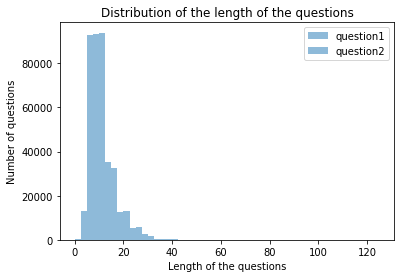

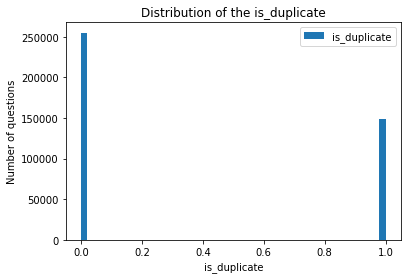

In [3]:
train = pd.read_csv('../quora-question-pairs/train.csv')
train = train.fillna('')
plt.hist(train['question1'].apply(lambda x: len(x.split())), bins=50, alpha=0.5, label='question1')
plt.title('Distribution of the length of the questions')
plt.xlabel('Length of the questions')
plt.ylabel('Number of questions')
plt.legend(['question1', 'question2'])
plt.show()

plt.hist(train['is_duplicate'], bins=50)
plt.title('Distribution of the is_duplicate')
plt.xlabel('is_duplicate')
plt.ylabel('Number of questions')
plt.legend(['is_duplicate'])
plt.show()

In [4]:
bias = train['is_duplicate'].sum() / len(train['is_duplicate'])
print('Bias in the is_duplicate tag: ', bias)
variance = train['is_duplicate'].var()
print('Variance in the is_duplicate tag: ', variance)

Bias in the is_duplicate tag:  0.369197853026293
Variance in the is_duplicate tag:  0.23289137439736537


In [5]:
train = train[:60000]
train, test, val = np.split(train.sample(frac=1), [int(.7*len(train)), int(.9*len(train))])

In [6]:
word2vec_file = '../quora-question-pairs/archive/GoogleNews-vectors-negative300.bin'
train.head()

,id,qid1,qid2,question1,question2,is_duplicate
4696,4696,9275,9276,What's 1 popular or rock song that's in 3/4 time?,What's one popular or rock song that's in 3/4 ...,1
13876,13876,26611,26612,How do I know my talents?,How could I know what my talents are?,1
46105,46105,31886,82505,Will India and Pakistan get along one day?,Is there anything I could do to help India and...,0
37846,37846,68808,68809,What software should I use for creating infogr...,What language should I use to create software?,0
44703,44703,80205,80206,Which is the best furniture shop in raipur?,What are some good furniture shops in secunder...,0


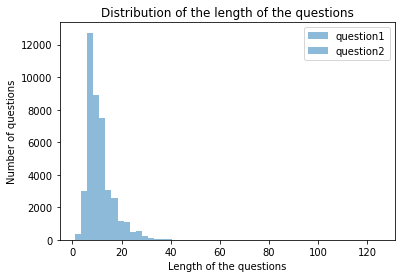

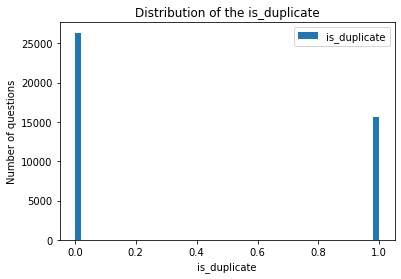

In [7]:
plt.hist(train['question1'].apply(lambda x: len(x.split())), bins=50, alpha=0.5, label='question1')
plt.title('Distribution of the length of the questions')
plt.xlabel('Length of the questions')
plt.ylabel('Number of questions')
plt.legend(['question1', 'question2'])
plt.show()

plt.hist(train['is_duplicate'], bins=50)
plt.title('Distribution of the is_duplicate')
plt.xlabel('is_duplicate')
plt.ylabel('Number of questions')
plt.legend(['is_duplicate'])
plt.show()


In [8]:
bias = train['is_duplicate'].sum() / len(train['is_duplicate'])
print('Bias in the is_duplicate tag: ', bias)
variance = train['is_duplicate'].var()
print('Variance in the is_duplicate tag: ', variance)

Bias in the is_duplicate tag:  0.3730476190476191
Variance in the is_duplicate tag:  0.2338886617481822


In [9]:
def Vocab(str):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(lower=False, split=' ')
    tokenizer.fit_on_texts(str)
    return tokenizer

word2vec_model = KeyedVectors.load_word2vec_format(word2vec_file, binary = True)

In [10]:
def SeqExt(str, tokenizer, seq_maxlen):
    reviews_seq = tokenizer.texts_to_sequences(str)
    arr = tf.keras.preprocessing.sequence.pad_sequences(reviews_seq, maxlen=seq_maxlen, padding='post')
    arr = np.array(arr)
    return arr

In [11]:
str = train['question1'].tolist()
str = str + train['question2'].tolist()
str = str + test['question1'].tolist()
str = str + test['question2'].tolist()
str = str + val['question1'].tolist()
str = str + val['question2'].tolist()

tokenizer = Vocab(str)
vocab_size = len(tokenizer.word_index)
vocab_size += 1
print(vocab_size)

x_train1 = SeqExt(train['question1'], tokenizer, 200)
x_train2 = SeqExt(train['question2'], tokenizer, 200)
y_train = tf.keras.utils.to_categorical(train['is_duplicate'])

x_test1 = SeqExt(test['question1'], tokenizer, 200)
x_test2 = SeqExt(test['question2'], tokenizer, 200)
y_test = tf.keras.utils.to_categorical(test['is_duplicate'])

x_val1 = SeqExt(val['question1'], tokenizer, 200)
x_val2 = SeqExt(val['question2'], tokenizer, 200)
y_val = tf.keras.utils.to_categorical(val['is_duplicate'])

46728


In [12]:
def EmbedMat(word2idx):    
    embedding_matrix = np.zeros((len(word2idx)+1, 300))
    for word, i in tqdm(word2idx.items()):
        embedding_vector = word2vec_model[word] if word in word2vec_model else np.random.rand(1,300)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix


In [13]:
embedmat = EmbedMat(tokenizer.word_index)
print(embedmat.shape)

100%|██████████| 46727/46727 [00:00<00:00, 97078.56it/s]

(46728, 300)


In [15]:
i1 = tf.keras.Input(shape=(x_train1.shape[1],))
i2 = tf.keras.Input(shape=(x_train2.shape[1],))

inner1= tf.keras.layers.Embedding(input_dim=embedmat.shape[0], output_dim=embedmat.shape[1], input_length=200, 
                                  weights=[embedmat], trainable=True)(i1)
inner2= tf.keras.layers.Embedding(input_dim=embedmat.shape[0], output_dim=embedmat.shape[1], input_length=200,
                                  weights=[embedmat], trainable=True)(i2)

inner1 = tf.keras.backend.sum(inner1, axis=1, keepdims=False)
inner = inner1
inner2 = tf.keras.backend.sum(inner2, axis=1, keepdims=False)
inner = inner+inner2

sz = [200, 120, 60, 2]
funInp = 'relu'
funOut = 'softmax'
inner = tf.keras.layers.Dense(sz[0], activation = funInp, kernel_regularizer = tf.keras.regularizers.l2(l2=0.01))(inner)
inner = tf.keras.layers.Dropout(0.1)(inner)
inner = tf.keras.layers.Dense(sz[1], activation = funInp, kernel_regularizer = tf.keras.regularizers.l2(l2=0.01))(inner)
inner = tf.keras.layers.Dropout(0.1)(inner)
inner = tf.keras.layers.Dense(sz[2], activation = funInp, kernel_regularizer = tf.keras.regularizers.l2(l2=0.01))(inner)
inner = tf.keras.layers.Dropout(0.1)(inner)
output = tf.keras.layers.Dense(sz[3], activation=funOut)(inner)

model = tf.keras.Model(inputs = [i1, i2], outputs = output)

In [16]:
model.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 200, 300)     14018400    ['input_3[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, 200, 300)     14018400    ['input_4[0][0]']                
                                                                                            

In [17]:
save_weights = tf.keras.callbacks.ModelCheckpoint('cbow.h5', monitor='val_loss', save_best_only=True)
checkpoint_filepath = 'weights.best.{epoch:01d}.hdf5'

history = model.fit((x_train1, x_train2), y_train,
                    batch_size = 64,
                    validation_data = ((x_val1, x_val2), y_val),
                    validation_batch_size = 64,
                    epochs=4, 
                    callbacks=[save_weights], 
                    verbose=1)

Epoch 1/4
657/657 [==============================] - 294s 442ms/step - loss: 1.1692 - accuracy: 0.6783 - val_loss: 0.5927 - val_accuracy: 0.7082
Epoch 2/4
657/657 [==============================] - 372s 566ms/step - loss: 0.5279 - accuracy: 0.7542 - val_loss: 0.5457 - val_accuracy: 0.7427
Epoch 3/4
657/657 [==============================] - 355s 541ms/step - loss: 0.4634 - accuracy: 0.7927 - val_loss: 0.5882 - val_accuracy: 0.7038
Epoch 4/4
657/657 [==============================] - 357s 544ms/step - loss: 0.4097 - accuracy: 0.8275 - val_loss: 0.6997 - val_accuracy: 0.7255


In [18]:
loss, accuracy = model.evaluate((x_test1, x_test2), y_test, batch_size=4, verbose=1)
print('Loss :', loss), print('Accuracy :', accuracy)

3000/3000 [==============================] - 15s 5ms/step - loss: 0.7404 - accuracy: 0.7134
Loss : 0.7404208183288574
Accuracy : 0.7134166955947876


(None, None)

In [19]:
pred = model.predict((x_test1, x_test2))
print('F1_score on test is', f1_score(np.argmax(pred, axis=1), np.argmax(y_test, axis=1)))

375/375 [==============================] - 4s 9ms/step
F1_score on test is 0.48525669809908695
